In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image as pil
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms as trans
from torchvision import models
from collections import OrderedDict
%matplotlib inline

In [0]:
def load(path, shape=None):
  ''' Input: image path
      Output: transformed - resized and normalized - image '''
  image = pil.open(path).convert('RGB')
  max_size = 1080
  if max(image.size) >= max_size:
      size = max_size
  else:
      size = max(image.size)
      
  if shape is not None:
        size = shape
  
  transform = trans.Compose([trans.Resize(size),trans.ToTensor(),
                            trans.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

  image = transform(image)[:3,:,:].unsqueeze(0)
  return image

device = torch.device("cuda")
content = load('/content/Taj.jpeg').to(device)
style = load('/content/Starry_Night.jpg',shape=content.shape[-2:]).to(device)
target = content.clone().requires_grad_(True).to(device)

In [0]:
def imshow(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return plt.imshow(image)

In [0]:
def extract_features(image, model, layers):

    features = {}
    x = image.to(device)
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [0]:
def gramian(tensor):

    b,d,h,w = tensor.shape
    tensor = tensor.view(d,h*w)
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

In [11]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

model = vgg
model.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:48<00:00, 11846358.44it/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
layers = {'0': 'conv1_1',
          '5': 'conv2_1',
          '10':'conv3_1',
          '19':'conv4_1',
          '21':'conv4_2',
          '28':'conv5_1'}

for i, l in enumerate(model):
  if isinstance(l, torch.nn.MaxPool2d):
    model[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
    
content_feat = extract_features(content, model, layers)
style_feat = extract_features(style, model, layers)
    
gram_matrix = {}
for l in style_feat:
  gram_matrix[l] = gramian(style_feat[l])

weights = {}
w = 1.
for l in layers:
  weights[layers[l]] = w
  w -= 0.15
  
content_weight = 1
style_weight = 5e3

Iteration: 500      Total loss: 33884.87
Iteration: 1000      Total loss: 12349.32
Iteration: 1500      Total loss: 5687.94
Iteration: 2000      Total loss: 2840.51
Iteration: 2500      Total loss: 1491.94
Iteration: 3000      Total loss: 813.78
Iteration: 3500      Total loss: 456.35
Iteration: 4000      Total loss: 261.8
Iteration: 4500      Total loss: 153.08
Iteration: 5000      Total loss: 90.95


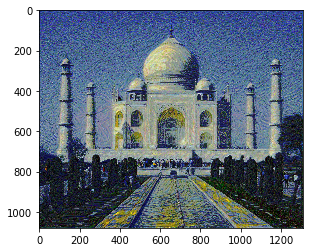

In [13]:
opt = torch.optim.Adam([target], lr=0.007)
epoch = 5000

for i in range(1, epoch+1):
    style_loss = 0
    target_feat = extract_features(target, model, layers)
    content_loss = torch.mean((target_feat['conv5_1'] - content_feat['conv5_1'])**2)
    
    for l in weights:
        target_f = target_feat[l]
        b, d, h, w = target_f.shape
        
        target_gram = gramian(target_f)
        gram_mat = gram_matrix[l]
        
        layer_style_loss = weights[l] * torch.mean((target_gram - gram_mat)**2)
        style_loss += layer_style_loss / (d * h * w)
        
    j = content_weight * content_loss + style_weight * style_loss
    
    opt.zero_grad()
    j.backward(retain_graph=True)
    opt.step()

    if i % 500 == 0:
      rounded_loss = round(j.item(), 2)
      print('Iteration:' , i , '     Total loss:' , rounded_loss)  
      imshow(target)
      plt.savefig('Starry_Taj.jpg')